# Test pcd loader


In this tutorial, we will train a _pointcloud_ classifier, in about five lines of code!

F

- [Downloading ModelNet10](#downloading-modelnet10)
- [DataLoading](#dataloading)
- [Training the pointcloud classifier](#training-the-pointcloud-classifier)
- [Bells and whistles](#bells-and-whistles)

## Downloading ModelNet10

Note that the ModelNet10 dataset is provided ONLY for the convenience of academic research. Should you choose to download it, you must adhere to the original terms and copyright notice of the dataset. For convenience, we reproduce the original copyright from the dataset creators.

```
**Copyright**

All CAD models are downloaded from the Internet and the original authors hold the copyright of the CAD models. The label of the data was obtained by us via Amazon Mechanical Turk service and it is provided freely. This dataset is provided for the convenience of academic research only.
```

The ModelNet10 (10-class subset) dataset is available on the [Princeton ModelNet page](https://modelnet.cs.princeton.edu/). On this page, navigate to the ModelNet10 download link to obtain the dataset. We assume that it is unzipped and extracted to a location `MODELNET_DIRECTORY`.

## Warm-up

Before all the fun-stuff begins, let us import all necessary functions from `kaolin` and `torch`. A bit more on what the following modules do will become clear as we progress.

In [1]:
import pixiedust
from tqdm import tqdm
import torch
print(torch.__version__)
from torch.utils.data import DataLoader
import kaolin as kal
from kaolin import ClassificationEngine

from kaolin.datasets_own import ModelNet as ModelNet2 #own, from_mesh
from kaolin.datasets import ModelNet #original, from_off

from kaolin.models.PointNet import PointNetClassifier
import kaolin.transforms as tfs
from IPython.core.debugger import set_trace

import time

Pixiedust database opened successfully


1.5.0


/home/cuda/anaconda3/envs/kaolin/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/cuda/anaconda3/envs/kaolin/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/cuda/anaconda3/envs/kaolin/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


   No module named 'nuscenes'
   None


Traceback (most recent call last):
  File "/home/cuda/anaconda3/envs/kaolin/lib/python3.6/site-packages/kaolin-0.1.0-py3.6-linux-x86_64.egg/kaolin/datasets/__init__.py", line 11, in <module>
    from .nusc import NuscDetection
  File "/home/cuda/anaconda3/envs/kaolin/lib/python3.6/site-packages/kaolin-0.1.0-py3.6-linux-x86_64.egg/kaolin/datasets/nusc.py", line 21, in <module>
    from nuscenes.utils.geometry_utils import transform_matrix
ModuleNotFoundError: No module named 'nuscenes'


## Dataloading

Kaolin provides convenience functions to load popular 3D datasets (of course, ModelNet10). Assuming you have [installed Kaolin](../../README.md#installation-and-usage), fire up your favourite python interpreter, and execute the following commands.

To start, we will define a few important parameters:

In [2]:
modelnet_path = '/home/cuda/kaolin/ModelNet10'
#categories = ['chair3', 'chair4','chair5','chair6', 'chair7','chair8']
categories = ['chair38', 'box','plant','ball','flask']
num_points = 1024
#set_trace()
device = 'cuda'
learning_rate=1e-3
epochs_nr=10

The `model_path` variable will hold the path to the ModelNet10 dataset. We will use the `categories` variable to specify which classes we want to learn to classify. `num_points` is the number of points we will sample from the mesh when transforming it to a pointcloud. Finally, we will use `device = 'cuda'` to tell pytorch to run everything on the GPU.

In [3]:
#%%pixie_debugger
transform = tfs.Compose([
    tfs.TriangleMeshToPointCloud(num_samples=num_points),
    tfs.NormalizePointCloud()
])

This command defines a `transform` that first converts a mesh representation to a pointcloud and then _normalizes_ it to be centered at the origin, and have a standard deviation of 1. Much like images, 3D data such as pointclouds need to be normalized for better classification performance.

In [4]:
#%%pixie_debugger
train_loader = DataLoader(ModelNet(modelnet_path, categories=categories,
                                   split='train', transform=transform),
                          batch_size=15, shuffle=True, num_workers=0, pin_memory=False)

In [5]:
val_loader = DataLoader(ModelNet(modelnet_path, categories=categories,
                                 split='test',transform=transform),
                        batch_size=10, num_workers=0, pin_memory=False)
val_batch, labels = next(iter(val_loader))

In [6]:
from sklearn.metrics import confusion_matrix
from kaolin.visualize import vis
from utils import visualize_batch
import itertools
import numpy as np
import matplotlib.pyplot as plt

/home/cuda/anaconda3/envs/kaolin/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/cuda/anaconda3/envs/kaolin/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [7]:
model = PointNetClassifier(num_classes=len(categories)).to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
start_time = time.time()

catlen=len(categories)

cmt = torch.zeros(catlen,catlen, dtype=torch.int64)
cmt_all = cmt
cm=cmt
cm_all=cmt

all_preds = torch.tensor([])
all_preds = all_preds.cuda()
all_real = torch.tensor([])
all_real = all_real.cuda()

for e in range(epochs_nr):

    print('###################')
    print('Epoch:', e)
    print('###################')

    train_loss = 0.
    train_accuracy = 0.
    num_batches = 0

    model.train()
    
    for idx, (data, attributes) in enumerate(tqdm(train_loader)):
        category = attributes['category'].cuda()
        pred = model(data.cuda())
        loss = criterion(pred, category.view(-1))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Compute accuracy
        pred_label = torch.argmax(pred, dim=1)
        train_accuracy += torch.mean((pred_label == category.view(-1)).float()).detach().cpu().item()
        num_batches += 1

    print('Train loss:', train_loss / num_batches)
    print('Train accuracy:', train_accuracy / num_batches)

    val_loss = 0.
    val_accuracy = 0.
    num_batches = 0

    model.eval()

    epoch_preds = torch.tensor([])
    epoch_preds = epoch_preds.cuda()
    epoch_real = torch.tensor([])
    epoch_real = epoch_real.cuda()
    
    cmt = torch.zeros(catlen,catlen, dtype=torch.int64)
    cm=cmt
    
    with torch.no_grad():
        for idx, (data, attributes) in enumerate(tqdm(val_loader)):
            category = attributes['category'].cuda()
            pred = model(data.cuda())
            loss = criterion(pred, category.view(-1))
            val_loss += loss.item()

            # Compute accuracy
            pred_label = torch.argmax(pred, dim=1)
            val_accuracy += torch.mean((pred_label == category.view(-1)).float()).cpu().item()
            num_batches += 1
               
            epoch_preds = torch.cat((epoch_preds, pred_label.float()),dim=0)
            epoch_real = torch.cat((epoch_real, category.view(-1).float()),dim=0)
            all_preds = torch.cat((all_preds, pred_label.float()),dim=0)
            all_real = torch.cat((all_real, category.view(-1).float()),dim=0)
    
    stacked = torch.stack((epoch_real,epoch_preds),dim=1)
    cm = confusion_matrix(epoch_real.cpu(), epoch_preds.cpu())

    for p in stacked:
        tl, pl = p.tolist()
        tl=int(tl)
        pl=int(pl)
        cmt[tl, pl] = cmt[tl, pl] + 1
        cmt_all[tl, pl] = cmt_all[tl, pl] + 1
                
    #print(cmt) 
    #print(cm)
    print('Val loss:', val_loss / num_batches)
    print('Val accuracy:', val_accuracy / num_batches)
end_time = time.time()
print('Training time: {}'.format(end_time - start_time))
print('conf. matrix cmt:')
#print(cmt_all)
cm_all = confusion_matrix(all_real.cpu(), all_preds.cpu())
print(cm_all)

  0%|          | 0/178 [00:00<?, ?it/s]

###################
Epoch: 0
###################


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss: 0.29858257996148607
Train accuracy: 0.9104869337647818


  0%|          | 0/178 [00:00<?, ?it/s]

Val loss: 0.34456896351650357
Val accuracy: 0.8944000129699707
###################
Epoch: 1
###################


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss: 0.11367869049865292
Train accuracy: 0.9715356023124094


  0%|          | 0/178 [00:00<?, ?it/s]

Val loss: 0.15577838149573653
Val accuracy: 0.9536000094413757
###################
Epoch: 2
###################


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss: 0.10474371223637227
Train accuracy: 0.9726591974161984


  0%|          | 0/178 [00:00<?, ?it/s]

Val loss: 0.24111611661873758
Val accuracy: 0.9184000105857849
###################
Epoch: 3
###################


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss: 0.09419868448801506
Train accuracy: 0.9704120082131932


  0%|          | 0/178 [00:00<?, ?it/s]

Val loss: 0.23631578537775202
Val accuracy: 0.9400000076293945
###################
Epoch: 4
###################


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss: 0.06857448818326896
Train accuracy: 0.9816479532236464


  0%|          | 0/178 [00:00<?, ?it/s]

Val loss: 0.14927104362472893
Val accuracy: 0.9512000093460083
###################
Epoch: 5
###################


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss: 0.07206666524053729
Train accuracy: 0.9786517013994496


  0%|          | 0/178 [00:00<?, ?it/s]

Val loss: 0.09963925769938942
Val accuracy: 0.9640000047683716
###################
Epoch: 6
###################


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss: 0.04095967149256017
Train accuracy: 0.9895131169410234


  0%|          | 0/178 [00:00<?, ?it/s]

Val loss: 0.14273362228670158
Val accuracy: 0.9592000074386596
###################
Epoch: 7
###################


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss: 0.031918613866999686
Train accuracy: 0.9925093701046505


  0%|          | 0/178 [00:00<?, ?it/s]

Val loss: 0.11251199397386517
Val accuracy: 0.9688000059127808
###################
Epoch: 8
###################


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss: 0.052380253702926635
Train accuracy: 0.9835206119531996


  0%|          | 0/178 [00:00<?, ?it/s]

Val loss: 0.13282555432076332
Val accuracy: 0.9600000052452088
###################
Epoch: 9
###################


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss: 0.05808787197927589
Train accuracy: 0.9812734220804793


100%|██████████| 125/125 [00:38<00:00,  3.26it/s]

Val loss: 0.14262047328474
Val accuracy: 0.9632000064849854
Training time: 1091.4794924259186
conf. matrix cmt:
[[3078    3   14    0    5]
 [  40 1997   12    1    0]
 [ 301   51 2969   34   55]
 [  30   12   42 1606   10]
 [   1    5   40    3 2191]]


Confusion matrix, without normalization
[[310   0   0   0   0]
 [  1 204   0   0   0]
 [ 21   6 308   3   3]
 [  0   2   9 159   0]
 [  0   0   0   1 223]]


Text(0.5, 24.535651198342336, 'Predicted label')

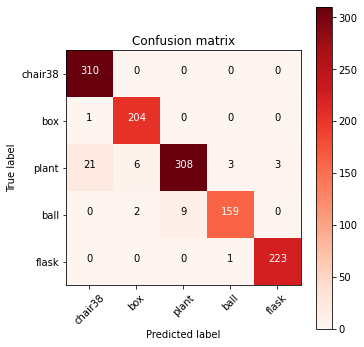

In [19]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(catlen,catlen))
cmf=cm
classes=categories
normalize=False
title='Confusion matrix'
cmap=plt.cm.Reds

if normalize:
    cmf = cmf.astype('float') / cmf.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
else:
    print('Confusion matrix, without normalization')

print(cmf)
plt.imshow(cmf, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = '.2f' if normalize else 'd'
thresh = cmf.max() / 2.
for i, j in itertools.product(range(cmf.shape[0]), range(cmf.shape[1])):
    plt.text(j, i, format(cmf[i, j], fmt), horizontalalignment="center", color="white" if cmf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Feed live data to evaluate them.

Iteration nr:19
box


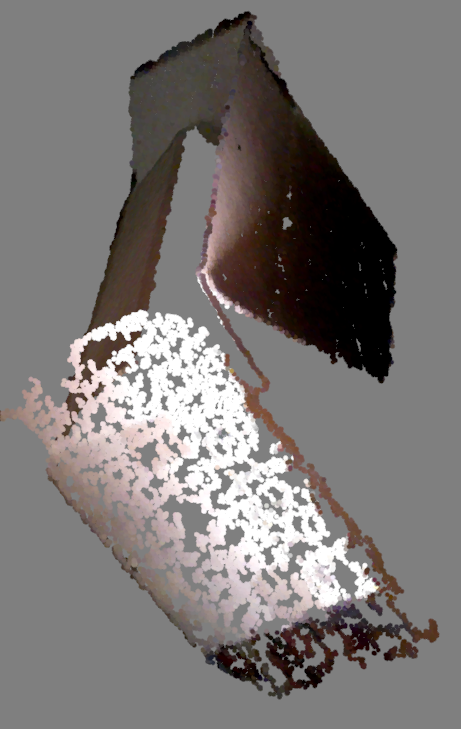

[0, 2, 1, 0, 17]


In [27]:
import matplotlib.image as mpimg
from IPython.display import Image
from IPython.display import display, clear_output

#prob=[0,0,0,0,0,0,0,0] #chair2,chair3,chair4,chair5,chair6,chair7,chair8,chair9
prob2=[0,0,0,0,0] #ball, box, chair38, flask, plant
stats=[]
stats2=[]

def test(i):
    test_loader = DataLoader(ModelNet2(modelnet_path, categories=['ball'],
                                 split='test',transform=transform, device=device),
                        shuffle=True, batch_size=1)

    test_batch, labels = next(iter(test_loader))
    preds = model(test_batch.data.cuda())
    #print(stat)
    
    pred_labels = torch.max(preds, axis=1)[1]
    
    #%matplotlib inline
    %matplotlib notebook
    get_ipython().run_line_magic('matplotlib', 'notebook')
    
    
    p=categories[pred_labels[0]]
    
    stat=preds.data.cpu().numpy()[0]
    #print(stat)
    for j in range (len(stat)):
        stat[j]=(stat[j]+10.0)*5
    
    stat=stat.astype(np.float)
    stats.append([])
    stats[i]=stat
    
    stat=np.append(stat,p)
    stats2.append([])
    stats2[i]=stat
    
    if p=='chair2':
        prob[0]=prob[0]+1
    if p=='chair3':
        prob[1]=prob[1]+1
    if p=='chair4':
        prob[2]=prob[2]+1
    if p=='chair5':
        prob[3]=prob[3]+1
    if p=='chair6':
        prob[4]=prob[4]+1
    if p=='chair7':
        prob[5]=prob[5]+1
    if p=='chair8':
        prob[6]=prob[6]+1
    if p=='chair9':
        prob[7]=prob[7]+1
    if p=='ball':
        prob2[0]=prob2[0]+1
        img = Image(filename='ball_point.png', width=100)
        image = mpimg.imread("ball_point.png") 
    if p=='box':
        prob2[1]=prob2[1]+1
        img = Image(filename='box_point.png', width=100)
        image = mpimg.imread("box_point.png") 
    if p=='chair38':
        prob2[2]=prob2[2]+1
        img = Image(filename='chair3_point.png', width=100)
        image = mpimg.imread("chair3_point.png") 
    if p=='flask':
        prob2[3]=prob2[3]+1
        img = Image(filename='flask_point.png', width=100)
        image = mpimg.imread("flask_point.png") 
    if p=='plant':
        prob2[4]=prob2[4]+1
        img = Image(filename='plant_point.png', width=100)
        image = mpimg.imread("plant_point.png") 
    #visualize_batch(test_batch, pred_labels, labels, categories)
    clear_output(wait=True)
    print("Iteration nr:" + str(i))
    print(p)
    display(img)
    time.sleep(1.0)

n=20
for i in range (n):
    test(i)
    
print(prob2)


In [ ]:
from tabulate import tabulate  
import numpy as np

st=stats2
lc=len(categories)

for i in range (len(stats)):
    row_dif=np.array([0.0])
    row_max=np.array([-10.0])
    for j in range (lc):
        element=stats[i][j].astype(np.float)
        if row_max<element:
            row_max=stats[i][j]
    for j in range (lc):
        row_dif=row_dif+(row_max-stats[i][j])       
    if lc>0:
        st[i]=np.append(st[i],row_dif/(lc-1))

cat=np.append(categories,'prediction')
#print (cat)
cat=np.append(cat,'average difference')
print(tabulate(st, headers=cat))

In [ ]:
#from fastai.vision import *
#from fastai.widgets import ClassConfusion